In [12]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
from eofs.xarray import Eof

In [13]:
#import dask to parallelise
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34729 instead
  warnings.warn(


In [14]:
#load in perturb data

In [15]:
from numpy.random import MT19937, RandomState, SeedSequence

In [16]:
seed = 1235

In [17]:
rs = RandomState(MT19937(SeedSequence(seed)))

In [18]:
amplitude = 0.00001# 10^-5

In [19]:
# Set up theta perturbation.
nlon = 360
nlat = 300
perturb = amplitude * (2.*rs.random(nlon*nlat).reshape((nlat,nlon)) - 1.)

In [20]:
# Set poles to zero (only necessary for ND grids, but doesn't hurt EG)
perturb[0] = 0.
perturb[-1] = 0.

In [21]:
perturb.shape

(300, 360)

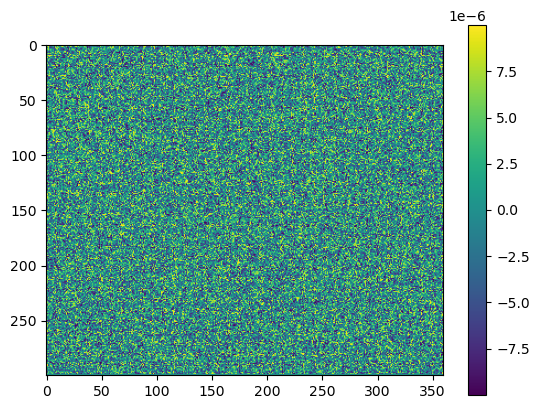

In [22]:
plt.imshow(perturb)
plt.colorbar()

In [23]:
#load in ctrl data
ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/Exps_ACCESS_initial/ctrl_sst.nc",  use_cftime=True, chunks= {"time":240})
ctrl = ctrl_sst.sst.compute()

In [24]:
def roll_lon(df):
    df.coords['xt_ocean'] = (df.coords['xt_ocean'] + 360) % 360# - 180
    df = df.sortby(df.xt_ocean)
    return df

In [25]:
ctrl = roll_lon(ctrl)

In [26]:
ctrl = ctrl.sel(time = slice("0951-01-01", "1150-12-31"))

In [27]:
def ssta(DS):
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta.drop("month")

In [28]:
def EP_CP_index(DS):
    """
    Calculate the Eastern Pacific (EP) and Central Pacific (CP) indices 
    based on the first two principal components (PCs) from an EOF analysis 
    of sea surface temperature anomalies (SSTAs), with adjustments based 
    on the sign of the EOFs at a specific location (250° longitude, 0° latitude).

    The function first computes the SST anomalies over a specified region 
    (140° to 280° longitude, -15° to 15° latitude) and then performs an EOF analysis.
    The sign of the first two EOFs at the specified location is used to adjust
    the sign of the corresponding PCs. The EP and CP indices are then calculated 
    from these adjusted PCs.

    Parameters:
    -----------
    DS : xarray.Dataset
        A dataset containing sea surface temperature data. The dataset should 
        include 'xt_ocean' and 'yt_ocean' coordinates.

    Returns:
    --------
    tuple of xarray.DataArray
        A tuple containing the EP and CP indices as xarray.DataArray objects.

    Notes:
    ------
    - The function assumes that the input dataset 'DS' has the necessary 
      fields and coordinates for the EOF analysis.
    - The SST anomaly is calculated internally within the function; 
      hence, 'DS' should contain absolute SST values.
    - The function uses the 'eofs.xarray' package for EOF analysis.
    - The weights for the EOF analysis are calculated as the square root 
      of the cosine of latitude.

    Example:
    --------
    >>> ds = xr.open_dataset('sst_data.nc')
    >>> ep_index, cp_index = EP_CP_index(ds)
    >>> print(ep_index, cp_index)
    """
    # Compute SST anomaly and select region
    sst_anom = ssta(DS)
    sst_anom = sst_anom.sel(xt_ocean=slice(140, 280), yt_ocean=slice(-15, 15))
    coslat = np.cos(np.deg2rad(sst_anom.coords['yt_ocean'].values))
    wgts = np.sqrt(coslat)[..., np.newaxis]

    # EOF analysis
    solver = Eof(sst_anom, weights=wgts)
    pcs = solver.pcs(npcs=2, pcscaling=1)

    # Calculate EOFs
    eofs_ = solver.eofsAsCovariance(neofs=4)
    
    # Check sign of EOFs at specific location
    eof1_val = eofs_.sel(mode=0, xt_ocean=250, yt_ocean=0, method="nearest").values
    eof2_val = eofs_.sel(mode=1, xt_ocean=250, yt_ocean=0, method="nearest").values

    # Adjust PCs based on EOF sign
    if eof1_val < 0:
        pc1= -pcs[:, 0]
    else:
        pc1 = pcs[:, 0]
    if eof2_val < 0:
        pc2 = pcs[:, 1]
    else:
        pc2 = -pcs[:, 1]

    # Calculate indices
    EP = (pc1 - pc2) / np.sqrt(2)
    CP = (pc1 + pc2) / np.sqrt(2)

    return EP, CP

In [29]:
def EP_CP_events(DS):
    EP, CP = EP_CP_index(DS)
    # Select SON seasons into a timeseries
    E_DJF = EP.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["DJF"]
    C_DJF = CP.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["DJF"]
    #get the Ep and CP events
    TH_E = E_DJF.std()
    EP_e = E_DJF.where(E_DJF >1* TH_E.values).dropna(dim="time")
    TH_C = C_DJF.std()
    CP_e = C_DJF.where(C_DJF >1* TH_C.values).dropna(dim="time")
    return EP_e.groupby('time.year').mean("time").year, CP_e.groupby('time.year').mean("time").year

In [30]:
def get_EPCP_times(ds_sst, ds_var=None):

    EP, CP = EP_CP_events(ds_sst)
    
    # Calculate the mean year for LN and EN
    EP_E = EP
    CP_E = CP
    
    # If ds_var is not provided, use ds_sst
    if ds_var is None:
        ds_var = ssta(ds_sst)
    
        
    # Initialize empty lists to store subsets
    epos_list = []
    epos_list2 = []
    cpos_list = []
    cpos_list2 = []    
    # Loop through each year group in ds_var and subset based on specific years in LN and EN
    for year, group in ds_var.groupby("time.year"):
        try:
            if year in EP_E:
                pos_subset = group
                epos_list.append(pos_subset)
                epos_list2.append(ds_var.groupby("time.year")[year+1])
            elif year in CP_E:
                pos_subset = group
                cpos_list.append(pos_subset)
                cpos_list2.append(ds_var.groupby("time.year")[year+1])
            else:
                pass
        except:
            print("some error, probs year is no in timeseries", year)
    
    # Concatenate subsets into a single DataArray
    esubset_ds_pos = xr.concat(epos_list, dim='time')
    esubset_ds_pos2 = xr.concat(epos_list2, dim='time')
    
    csubset_ds_pos = xr.concat(cpos_list, dim='time')
    csubset_ds_pos2 = xr.concat(cpos_list2, dim='time')
    
    #now groupby month to get the monhtly evolution of EP and CP events
    esubset_ds_pos = esubset_ds_pos.groupby("time.month").mean("time")
    esubset_ds_pos2 = esubset_ds_pos2.groupby("time.month").mean("time")
    csubset_ds_pos = csubset_ds_pos.groupby("time.month").mean("time")
    csubset_ds_pos2 = csubset_ds_pos2.groupby("time.month").mean("time")
       
    return esubset_ds_pos, esubset_ds_pos2, csubset_ds_pos, csubset_ds_pos2

In [31]:
ctrl = ctrl.drop({"geolon_t", "geolat_t"})

In [32]:
ep1, ep2, cp1, cp2 = get_EPCP_times(ctrl)

In [33]:
#write fucntion ot put the dtaa in the correct dimensions

In [34]:
#roll longitudes back to original longitudes to match climatology file
def roll_lon_back(df):
    df.coords['xt_ocean'] = (df.coords['xt_ocean'] +280 ) % 360 -280
    df = df.sortby(df.xt_ocean)
    return df

In [35]:
def rename_expand_dims(da):
    da = roll_lon_back(da)
    da = da.rename({"xt_ocean": "GRID_X_T",
                        "yt_ocean":"GRID_Y_T", "month":"TIME"})
    #add the depth coord
    da = da.expand_dims(dim =  {"DEPTH1_1":model_clim.DEPTH1_1})
    da = da.assign_coords({"GRID_X_T": model_clim.GRID_X_T,
                           "GRID_Y_T": model_clim.GRID_Y_T,
                           "DEPTH1_1":model_clim.DEPTH1_1,
                          "TIME": model_clim.TIME})
    return da

In [36]:
#now lets load in the SST climatology and add the composites to get the evolution of model_clim + EP(CP) El Nino

In [37]:
model_clim = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/global_sst_restoring_cm000_climatology_0951-1150.nc", decode_cf=False)

In [38]:
EP1 = rename_expand_dims(ep1)
EP2 = rename_expand_dims(ep2)
CP1 = rename_expand_dims(cp1)
CP2 = rename_expand_dims(cp2)


In [39]:
def mask_jan_mar(da):
    da = da.where((da.TIME > 4*30) | da.isnull(), other=0)
    return da

In [40]:
#mask jan-mar for year 1

In [41]:
EP1 = mask_jan_mar(EP1)
CP1 = mask_jan_mar(CP1)


In [42]:
EP1_clim = EP1+model_clim.temp
EP2_clim = EP2+model_clim.temp
CP1_clim = CP1+model_clim.temp
CP2_clim = CP2+model_clim.temp

In [43]:
#now add the perturbation to Jan only

In [44]:
perturb_xr = xr.DataArray(perturb, {'GRID_Y_T' : model_clim.GRID_Y_T, 'GRID_X_T' : model_clim.GRID_X_T})

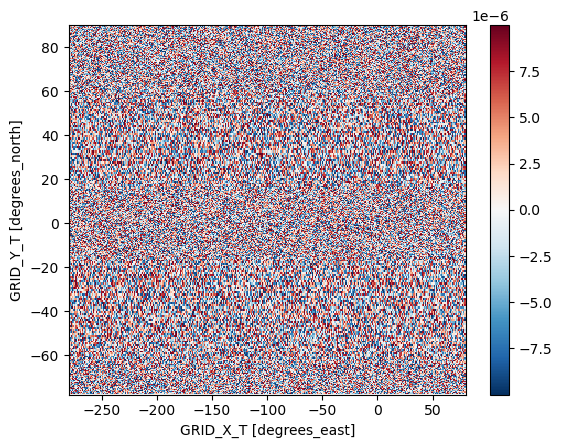

In [45]:
perturb_xr.plot()

In [46]:
def add_perturbation_to_first_time(original_array, perturbation_array):
    """
    Add a perturbation array to the first time step of a given Xarray dataset or data array.
    
    Parameters:
    original_array (xarray.Dataset or xarray.DataArray): The original dataset or data array.
    perturbation_array (xarray.Dataset or xarray.DataArray): The array containing the perturbation values.
    
    Returns:
    xarray.Dataset or xarray.DataArray: The modified dataset or data array with perturbation added to the first time step.
    """
    # Select the first time step of the original array
    first_time_step = original_array.isel(TIME=0)
    
    # Add the perturbation to the first time step
    modified_first_time_step = first_time_step + perturbation_array
    
    # Create a deep copy of the original array
    modified_array = original_array.copy(deep=True)
    
    # Assign the modified first time step back to the original array
    modified_array[{'TIME': 0}] = modified_first_time_step
    
    return modified_array

In [47]:
CP1_clim_old = CP1_clim
EP1_clim_old = EP1_clim


In [48]:
CP1_clim = add_perturbation_to_first_time(CP1_clim, perturb_xr)

In [49]:
EP1_clim = add_perturbation_to_first_time(EP1_clim, perturb_xr)

In [50]:
#just check it worked

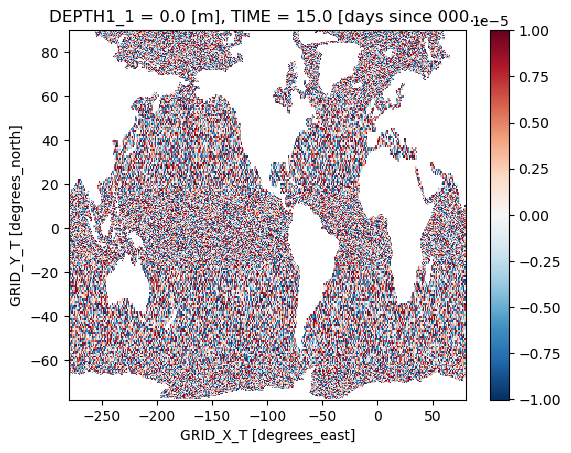

In [51]:
(EP1_clim[0,0] - EP1_clim_old[0,0]).plot()

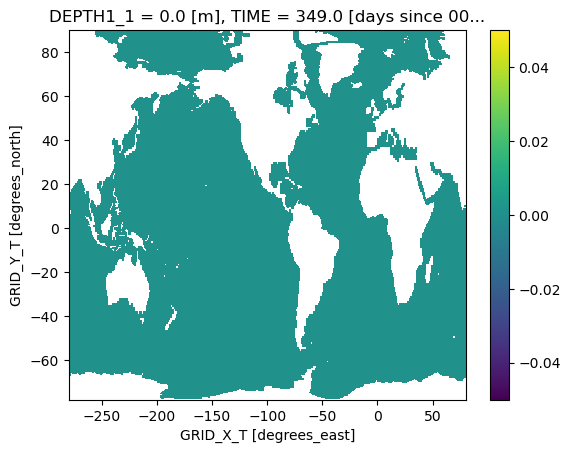

In [52]:
(EP1_clim[0,11] - EP1_clim_old[0,11]).plot()

In [112]:
#now save data

In [53]:
EP1_clim = EP1_clim.assign_attrs({"long_name": "Climatology SST restoring", "units": "degrees K", "valid_range": np.array([-10., 500.], dtype=np.float32)})
EP1_clim = EP1_clim.to_dataset(name = 'temp')
EP1_clim =EP1_clim.assign_attrs({"description": "Monthly Sea Surface Temperature (SST) evolution for the EP (Eastern Pacific) El Nino during year 0, identified at the peak months of December, January, and February, is generated. This data is derived from the combination of cm000 SST climatology and cm000 SST anomalies. EP El Nino events are classified based on cm000 spanning 951-1150, utilizing Sea Surface Temperature Anomalies (SSTA). The classification method follows Takahashi et al. (2011) (doi:10.1029/2011GL047364). Jan of year 0 perturbed by 1e-5 using numpy.RandomState(MT19937(SeedSequence(1235))). For ACCESS-CM2 pacemaker experiments, Sebastian McKenna",
                                 "history": "Created 25/03/24"})

EP1_clim = EP1_clim[["TIME", "DEPTH1_1", "GRID_Y_T", "GRID_X_T", "temp"]]
# Save the data array to the output file
EP1_clim.to_netcdf("/g/data/e14/sm2435/Pacemaker/Mod_ENSO_pert1/EP_elnino_year0.nc", encoding = {"TIME": {"_FillValue": None},
                                                        "DEPTH1_1": {"_FillValue": None},
                                                        "GRID_Y_T": {"_FillValue": None},
                                                        "GRID_X_T": {"_FillValue": None},
                                                        "temp": {"_FillValue": -1.e+20}}, unlimited_dims="TIME")

In [54]:
EP2_clim = EP2_clim.assign_attrs({"long_name": "Climatology SST restoring", "units": "degrees K", "valid_range": np.array([-10., 500.], dtype=np.float32)})
EP2_clim = EP2_clim.to_dataset(name = 'temp')
EP2_clim = EP2_clim.assign_attrs({"description": "Monthly Sea Surface Temperature (SST) evolution for the EP (Eastern Pacific) El Nino during year 1, identified at the peak months of December, January, and February, is generated. This data is derived from the combination of cm000 SST climatology and cm000 SST anomalies. EP El Nino events are classified based on cm000 spanning 951-1150, utilizing Sea Surface Temperature Anomalies (SSTA). The classification method follows Takahashi et al. (2011) (doi:10.1029/2011GL047364). Jan of year 0 perturbed by 1e-5 using numpy.RandomState(MT19937(SeedSequence(1235))). For ACCESS-CM2 pacemaker experiments, Sebastian McKenna",
                                 "history": "Created 25/03/24"})

EP2_clim = EP2_clim[["TIME", "DEPTH1_1", "GRID_Y_T", "GRID_X_T", "temp"]]
# Save the data array to the output file
EP2_clim.to_netcdf("/g/data/e14/sm2435/Pacemaker/Mod_ENSO_pert1/EP_elnino_year1.nc", encoding = {"TIME": {"_FillValue": None},
                                                        "DEPTH1_1": {"_FillValue": None},
                                                        "GRID_Y_T": {"_FillValue": None},
                                                        "GRID_X_T": {"_FillValue": None},
                                                        "temp": {"_FillValue": -1.e+20}}, unlimited_dims="TIME")

In [55]:
CP1_clim = CP1_clim.assign_attrs({"long_name": "Climatology SST restoring", "units": "degrees K", "valid_range": np.array([-10., 500.], dtype=np.float32)})
CP1_clim = CP1_clim.to_dataset(name = 'temp')
CP1_clim = CP1_clim.assign_attrs({"description": "Monthly Sea Surface Temperature (SST) evolution for the CP (Central Pacific) El Nino during year 0, identified at the peak months of December, January, and February, is generated. This data is derived from the combination of cm000 SST climatology and cm000 SST anomalies. EP El Nino events are classified based on cm000 spanning 951-1150, utilizing Sea Surface Temperature Anomalies (SSTA). The classification method follows Takahashi et al. (2011) (doi:10.1029/2011GL047364). Jan of year 0 perturbed by 1e-5 using numpy.RandomState(MT19937(SeedSequence(1235))). For ACCESS-CM2 pacemaker experiments, Sebastian McKenna",
                                 "history": "Created 25/03/24"})

CP1_clim = CP1_clim[["TIME", "DEPTH1_1", "GRID_Y_T", "GRID_X_T", "temp"]]
# Save the data array to the output file
CP1_clim.to_netcdf("/g/data/e14/sm2435/Pacemaker/Mod_ENSO_pert1/CP_elnino_year0.nc", encoding = {"TIME": {"_FillValue": None},
                                                        "DEPTH1_1": {"_FillValue": None},
                                                        "GRID_Y_T": {"_FillValue": None},
                                                        "GRID_X_T": {"_FillValue": None},
                                                        "temp": {"_FillValue": -1.e+20}}, unlimited_dims="TIME")

In [56]:
CP2_clim = CP2_clim.assign_attrs({"long_name": "Climatology SST restoring", "units": "degrees K", "valid_range": np.array([-10., 500.], dtype=np.float32)})
CP2_clim = CP2_clim.to_dataset(name = 'temp')
CP2_clim = CP2_clim.assign_attrs({"description": "Monthly Sea Surface Temperature (SST) evolution for the CP (Central Pacific) El Nino during year 1, identified at the peak months of December, January, and February, is generated. This data is derived from the combination of cm000 SST climatology and cm000 SST anomalies. EP El Nino events are classified based on cm000 spanning 951-1150, utilizing Sea Surface Temperature Anomalies (SSTA). The classification method follows Takahashi et al. (2011) (doi:10.1029/2011GL047364). Jan of year 0 perturbed by 1e-5 using numpy.RandomState(MT19937(SeedSequence(1235))). For ACCESS-CM2 pacemaker experiments, Sebastian McKenna",
                                 "history": "Created 25/03/24"})

CP2_clim = CP2_clim[["TIME", "DEPTH1_1", "GRID_Y_T", "GRID_X_T", "temp"]]
# Save the data array to the output file
CP2_clim.to_netcdf("/g/data/e14/sm2435/Pacemaker/Mod_ENSO_pert1/CP_elnino_year1.nc", encoding = {"TIME": {"_FillValue": None},
                                                        "DEPTH1_1": {"_FillValue": None},
                                                        "GRID_Y_T": {"_FillValue": None},
                                                        "GRID_X_T": {"_FillValue": None},
                                                        "temp": {"_FillValue": -1.e+20}}, unlimited_dims="TIME")

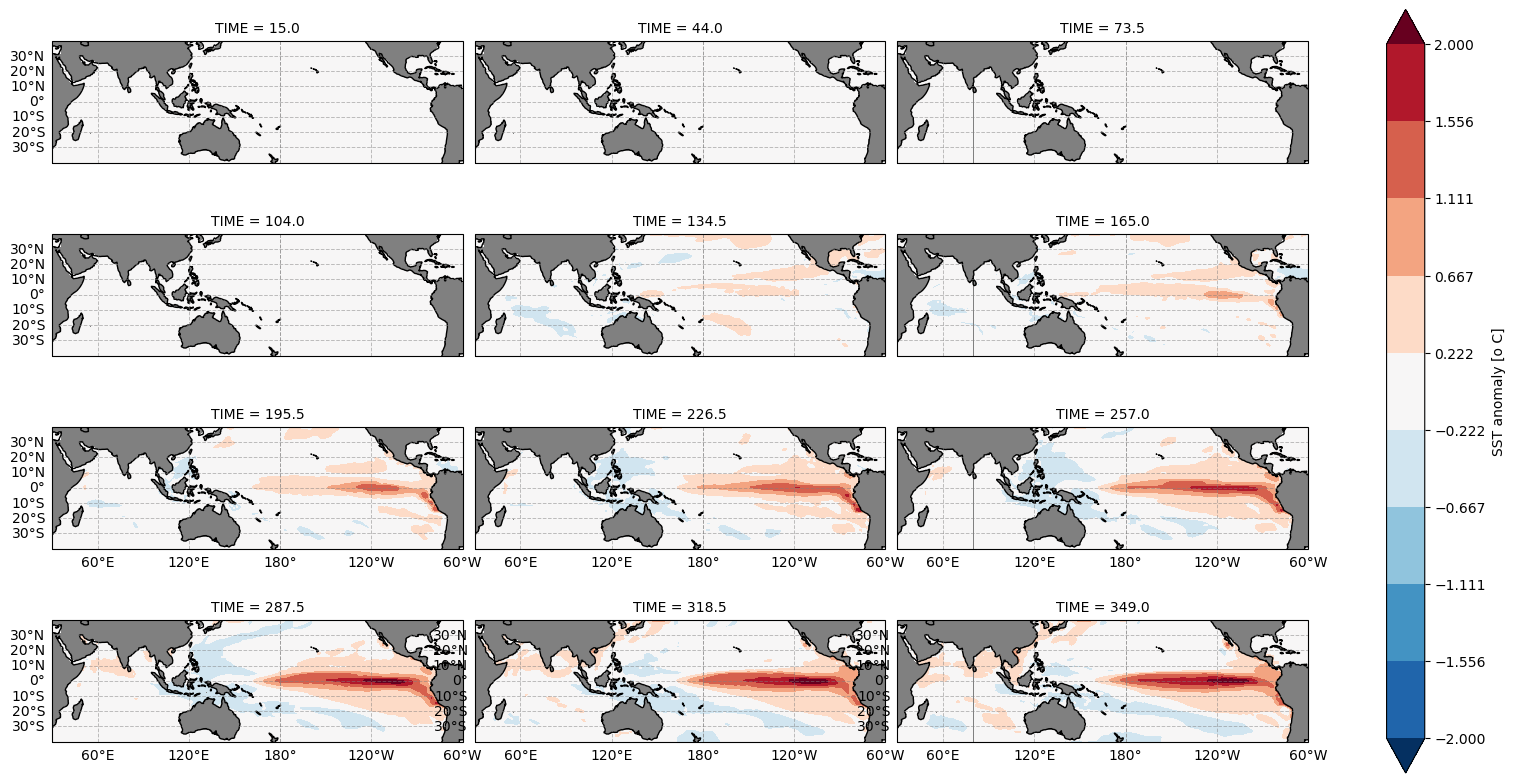

In [76]:
lat_limits = (-40, 40)
lon_limits = (-150, 120) 
fg = EP1[0].plot.contourf(col="TIME", col_wrap = 3, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5]:
        gl.bottom_labels = False
    if i in [1,2,4,5,7,8]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

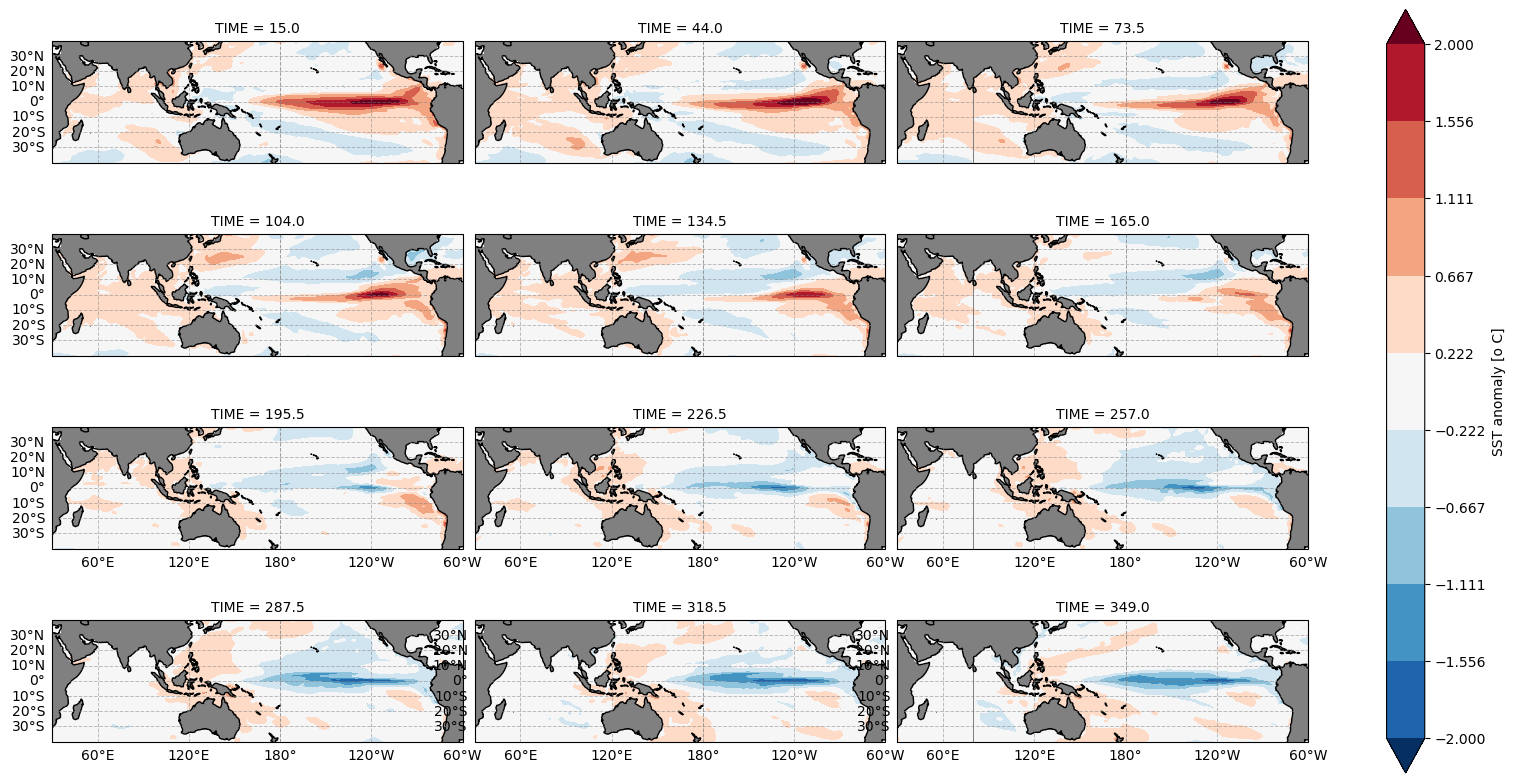

In [52]:
lat_limits = (-40, 40)
lon_limits = (-150, 120) 
fg = EP2[0].plot.contourf(col="TIME", col_wrap = 3, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5]:
        gl.bottom_labels = False
    if i in [1,2,4,5,7,8]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

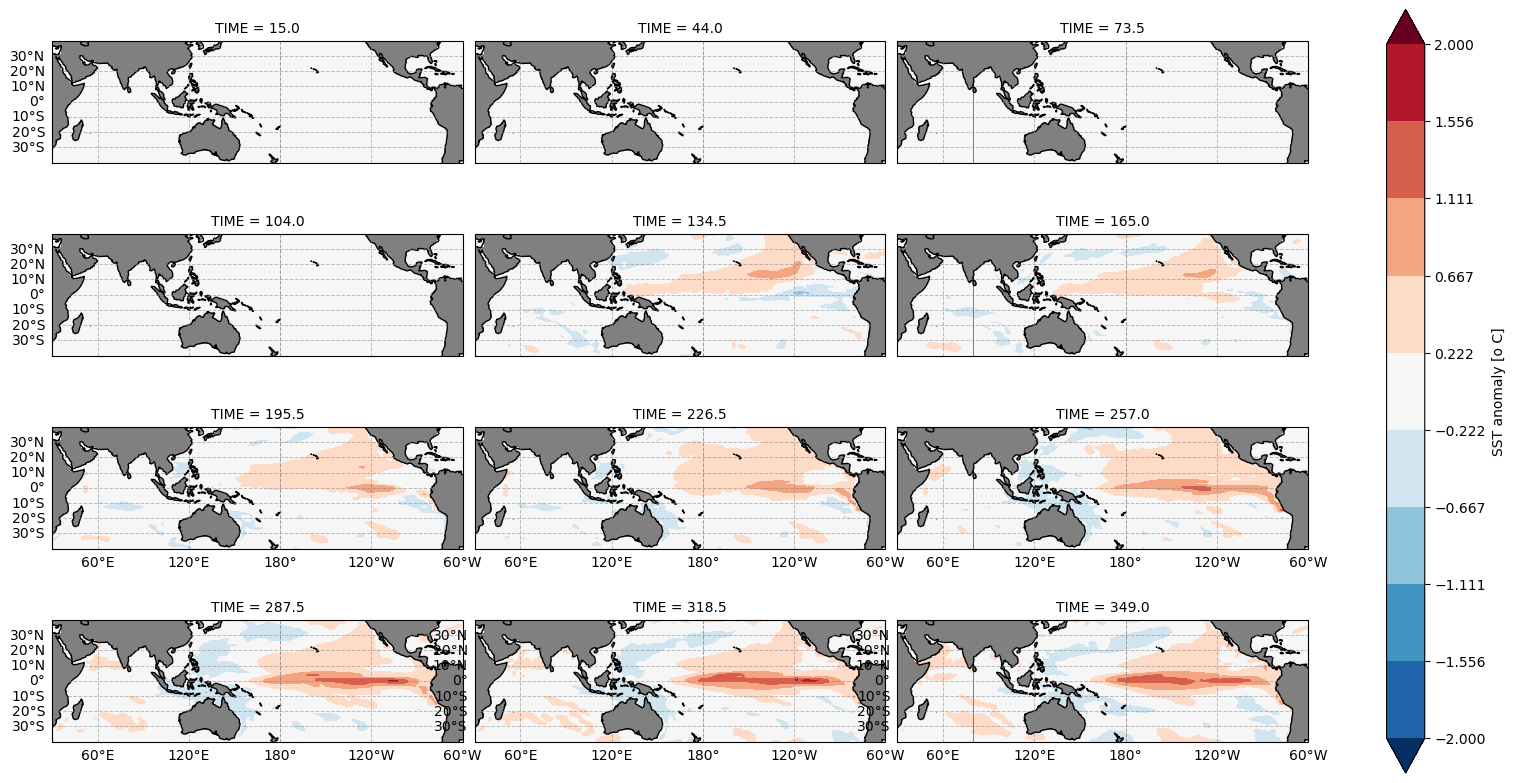

In [53]:
lat_limits = (-40, 40)
lon_limits = (-150, 120) 
fg = CP1[0].plot.contourf(col="TIME", col_wrap = 3, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5]:
        gl.bottom_labels = False
    if i in [1,2,4,5,7,8]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  

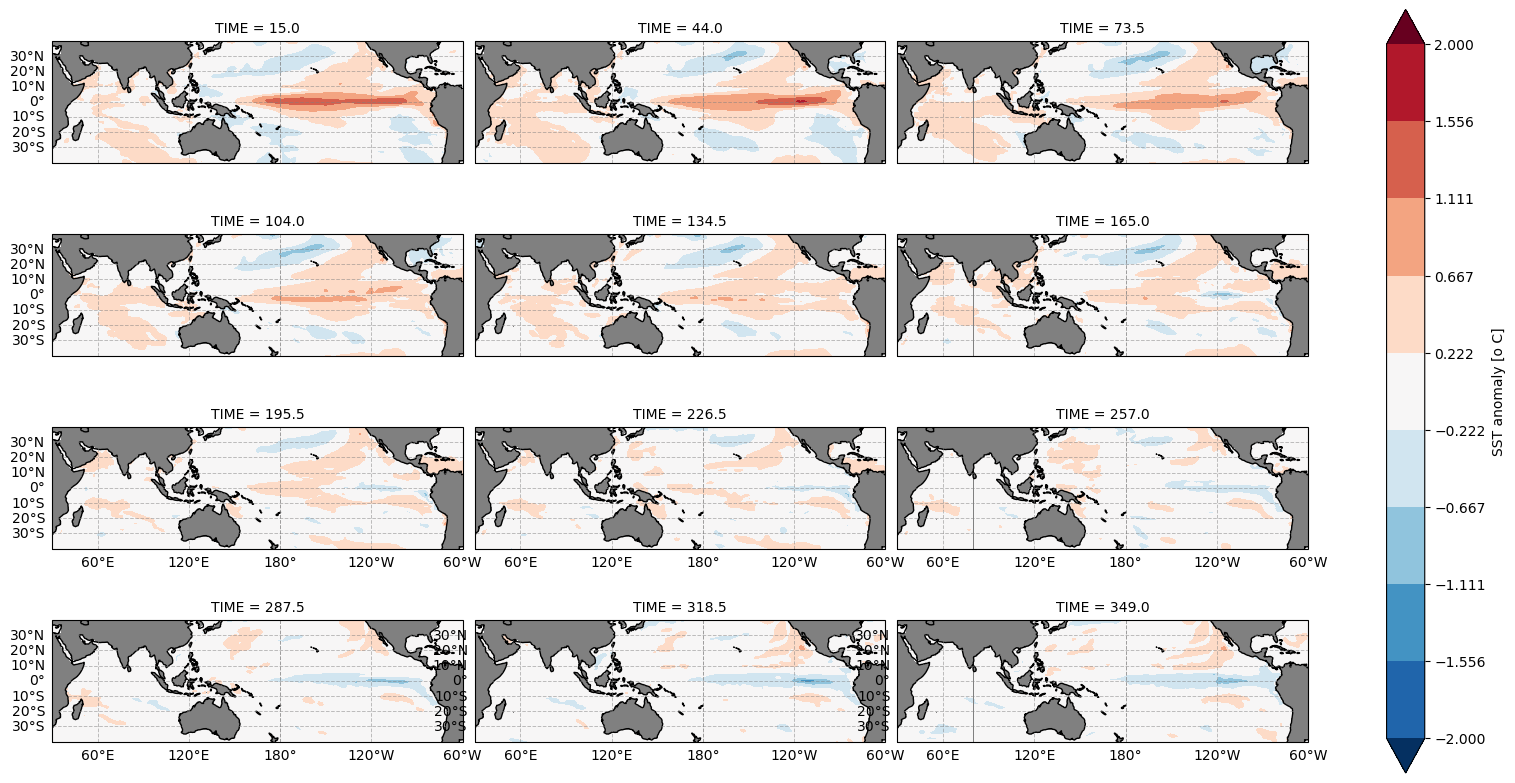

In [54]:
lat_limits = (-40, 40)
lon_limits = (-150, 120) 
fg = CP2[0].plot.contourf(col="TIME", col_wrap = 3, transform=ccrs.PlateCarree(),
                subplot_kws={"projection": ccrs.PlateCarree(central_longitude = 180), "xlim": lon_limits, "ylim": lat_limits},
                          figsize=(16,8), vmin = -2, levels =10, extend = 'both',  cmap = 'RdBu_r',
                            cbar_kwargs=dict(label='SST anomaly [o C]'))
for i, ax in enumerate(fg.axs.flat):
    ax.coastlines()
    ax.set_facecolor('grey')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')

    if i in [0,1,2,3,4,5]:
        gl.bottom_labels = False
    if i in [1,2,4,5,7,8]:
        gl.left_labels = False
    gl.top_labels = False
    gl.right_labels = False  